In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import scipy.optimize
import matplotlib.pyplot as plt
#import torch
from modelling_fctns import double_logistic, normalized_difference
import data_cleaning
import LSP

import libtlda.tca

import adapt.feature_based

import cv2
from PIL import Image

import scipy.signal
from scipy.interpolate import make_smoothing_spline
#

In [2]:
ds = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\MODIS\\Kenya\\satdata0.csv')
ds = data_cleaning.add_SOS_to_df(ds)
ds = data_cleaning.add_EOS_to_df(ds)
ds['NDVI'] = normalized_difference(ds['median sur_refl_b02'], ds['median sur_refl_b01'])
max_value_interpolated = data_cleaning.map_max_value_int(ds, window_size=8)
array_input = data_cleaning.make_df_samples(max_value_interpolated, sample_number = 1000, m_window_size = 5)
sampled_locs_input = data_cleaning.make_tensor_from_timeseries(max_value_interpolated, sample_number = 100, m_window_size = 5, format_choice = 'numpy')

In [3]:
ds2 = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\MODIS\\Germany\\satdata0.csv')
ds2 = data_cleaning.add_SOS_to_df(ds2)
ds2 = data_cleaning.add_EOS_to_df(ds2)
ds2['NDVI'] = normalized_difference(ds2['median sur_refl_b02'], ds2['median sur_refl_b01'])
max_value_interpolated2 = data_cleaning.map_max_value_int(ds2, window_size=8)
array_input2 = data_cleaning.make_df_samples(max_value_interpolated2, sample_number = 1000, m_window_size = 5)
sampled_locs_input2 = data_cleaning.make_tensor_from_timeseries(max_value_interpolated2, sample_number = 100, m_window_size = 5, format_choice = 'numpy')

In [18]:
def autocorrelation_matrix(ds, variable = 'NDVI', index_coord = 'index'):
    X = (ds[variable] - ds[variable].mean(dim='sample')).values
    return np.corrcoef(X.T)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(autocorrelation_matrix(array_input, variable = 'NDVI', index_coord = 'index'), vmin = 0, vmax = 1, cmap = 'Purples')
axs[0].set_ylabel('Time in window (0 is first element)')
axs[0].set_xlabel('Time in window (0 is first element)')
axs[1].imshow(autocorrelation_matrix(array_input2, variable = 'NDVI', index_coord = 'index'), vmin = 0, vmax = 1, cmap = 'Purples')
axs[1].set_xlabel('Time in window (0 is first element)')
axs[0].set_title('Kenya')
axs[1].set_title('Germany')
fig.suptitle('Correlation between times in a window of NDVI timeseries', fontsize = 20)

In [2]:
def cross_percentile_date(smoothed_series, percentile):
    # Calculate the 90th percentile
    percentile_value = np.percentile(smoothed_series, 10)
    # Identify when the time series crosses the 90th percentile
    crosses_percentile = (smoothed_series > percentile_value).astype(int).diff().fillna(0).astype(bool)

    # Extract the dates when the crossing occurs
    crossing_dates = smoothed_series.index[crosses_percentile]
    return(crossing_dates)

def double_logistic_LSP(values, Times, first_date):
    Tighter_times = np.arange(Times[0], Times[-1], 1)
    params, _ = scipy.optimize.curve_fit(modelling_fctns.double_logistic, Times/365, values, maxfev = 10000)
    smoothed_series = pd.Series(modelling_fctns.double_logistic(Tighter_times/365, *params), index=Tighter_times/365)
    max_green = first_date + pd.Timedelta(Tighter_times[np.int64(smoothed_series.idxmax()*365)], 'D')
    percentile_10 = first_date + pd.Timedelta(cross_percentile_date(smoothed_series, 10)[0]*365, 'D')
    percentile_50 = first_date + pd.Timedelta(cross_percentile_date(smoothed_series, 50)[0]*365, 'D')
    percentile_90 = first_date + pd.Timedelta(cross_percentile_date(smoothed_series, 90)[0]*365, 'D')
    percentile_10_2nd = first_date + pd.Timedelta(cross_percentile_date(smoothed_series, 10)[-1]*365, 'D')
    return percentile_10, percentile_50, percentile_90, percentile_10_2nd, max_green

def spline_LSP(values, Times, first_date):
    Tighter_times = np.arange(Times[0], Times[-1], 1)
    spl = make_smoothing_spline(Times/365, values, lam = 0.00001)
    smoothed_series = pd.Series(spl(Tighter_times/365), index=Tighter_times/365)
    #print(Tighter_times/365, smoothed_series.idxmax(), smoothed_series)
    max_green = first_date + pd.Timedelta(Tighter_times[np.int64(smoothed_series.idxmax()*365)], 'D')
    percentile_10 = first_date + pd.Timedelta(cross_percentile_date(smoothed_series, 10)[0]*365, 'D')
    percentile_50 = first_date + pd.Timedelta(cross_percentile_date(smoothed_series, 50)[0]*365, 'D')
    percentile_90 = first_date + pd.Timedelta(cross_percentile_date(smoothed_series, 90)[0]*365, 'D')
    percentile_10_2nd = first_date + pd.Timedelta(cross_percentile_date(smoothed_series, 10)[-1]*365, 'D')
    print(spl(Tighter_times[np.int64(smoothed_series.idxmax()*365)]/365), max_green, spl(Tighter_times/365).max())
    return percentile_10, percentile_50, percentile_90, percentile_10_2nd, max_green

def savgol_LSP(values, Times, first_date):
    smoothed_series = pd.Series(scipy.signal.savgol_filter(values, window_length=6, polyorder=3, deriv=0), index=Times)
    smoothed_derivs = pd.Series(scipy.signal.savgol_filter(values, window_length=6, polyorder=3, deriv=1), index=Times)
    mingrad = first_date + pd.Timedelta(smoothed_derivs.idxmin(), 'D')
    maxgrad = first_date + pd.Timedelta(smoothed_derivs.idxmax(), 'D')
    minday = first_date + pd.Timedelta(smoothed_series.idxmin(), 'D')
    maxday = first_date + pd.Timedelta(smoothed_series.idxmax(), 'D')
    return mingrad, maxgrad, minday, maxday

def initialize_LSP_frame(LSP_method):
    if LSP_method == 'double_logistic' or LSP_method == 'spline':
        results = pd.DataFrame(columns = ['year', 'Stations_Id', 'percentile_10', 'percentile_50', 'percentile_90', 'percentile_10_2nd', 'max_green'])
    elif LSP_method == 'savgol':
        results = pd.DataFrame(columns = ['year', 'Stations_Id', 'mingrad', 'maxgrad', 'minday', 'maxday'])
    return results

def append_LSP_frame(results, LSPs):
    results.loc[-1] = LSPs
    results.index = results.index + 1
    results = results.sort_index()
    return results

def calculate_append_LSP_frame(results, values, Times, first_date, LSP_method, year, station):
    if LSP_method == 'double_logistic' or LSP_method == 'spline':
        if LSP_method == 'double_logistic':
            LSPs = double_logistic_LSP(values, Times, first_date)
        else:
            LSPs = spline_LSP(values, Times, first_date)
        results = append_LSP_frame(results, [year, station, *LSPs])
    elif LSP_method == 'savgol':
        LSPs = savgol_LSP(values, Times, first_date)
        results = append_LSP_frame(results, [year, station, *LSPs])
    return results

def LSP_at_stations(ds, start_year, end_year, LSP_method = 'double_logistic'):
    results = initialize_LSP_frame(LSP_method)
    print(results)
    for year in range(start_year, end_year + 1):
        print(f'Year: {year}')
        for station in ds['Stations_Id'].unique():
            ds_station = ds.loc[ds['Stations_Id'] == station]
            ds_station_year = data_cleaning.restrict_to_growing_season(ds_station, year, ds_station['SOS'].iloc[0], ds_station['EOS'].iloc[0])
            if len(ds_station_year) > 0:
                print(f'Station {station} in {year} has {len(ds_station_year)} observations')
            else:
                print(f'Station {station} in {year} has no observations')
                continue
            max_value_interpolated = data_cleaning.map_max_value_int(ds_station_year, window_size=4) #data_cleaning.
            first_date = pd.DatetimeIndex(max_value_interpolated['time']).min()
            Times = (pd.DatetimeIndex(max_value_interpolated['time']) - pd.DatetimeIndex(max_value_interpolated['time']).min()).days.values
            NDVIs = max_value_interpolated['NDVI'].values
            try:
                results = calculate_append_LSP_frame(results, NDVIs, Times, first_date, LSP_method, year, station)
            except:
                print(f'Couldn\'t compute LSP for station {station} in year {year}')
                continue
    return results

In [2]:
ds = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\MODIS\\Germany\\satdata0_GER.csv')
ds = data_cleaning.add_EOS_to_df(ds)
ds = data_cleaning.add_SOS_to_df(ds)
ds['NDVI'] = normalized_difference(ds['median sur_refl_b02'], ds['median sur_refl_b01'])
LSP_times = LSP.LSP_at_stations(ds, 2020, 2021, LSP_method='savgol', interp_method='linear')

Empty DataFrame
Columns: [year, Stations_Id, mingrad, maxgrad, minday, maxday]
Index: []
Year: 2020
Station 7501 in 2020 has 89 observations
          time  Unnamed: 0          Time      lat     lon  Stations_Id  \
0   2020-03-25        84.0  1.585094e+12  54.7833  9.4333       7501.0   
1   2020-03-26        85.0  1.585181e+12  54.7833  9.4333       7501.0   
2   2020-03-27        86.0  1.585267e+12  54.7833  9.4333       7501.0   
3   2020-03-28        87.0  1.585354e+12  54.7833  9.4333       7501.0   
4   2020-03-29        88.0  1.585440e+12  54.7833  9.4333       7501.0   
..         ...         ...           ...      ...     ...          ...   
224 2020-11-04       308.0  1.604448e+12  54.7833  9.4333       7501.0   
225 2020-11-05       309.0  1.604534e+12  54.7833  9.4333       7501.0   
226 2020-11-06       310.0  1.604621e+12  54.7833  9.4333       7501.0   
227 2020-11-07       311.0  1.604707e+12  54.7833  9.4333       7501.0   
228 2020-11-08       312.0  1.604794e+12  54.

In [7]:
LSP_times

,year,Stations_Id,mingrad,maxgrad,minday,maxday
0,2021,7569,2021-04-24,2021-04-26,2021-09-27,2021-06-19
1,2021,7568,2021-08-07,2021-08-05,2021-08-03,2021-06-26
2,2021,7566,2021-08-05,2021-08-07,2021-07-24,2021-06-29
3,2021,7565,2021-10-29,2021-04-16,2021-04-10,2021-08-29
4,2021,7564,2021-04-11,2021-09-19,2021-07-28,2021-11-07
...,...,...,...,...,...,...
95,2020,7507,2020-09-28,2020-10-01,2020-04-26,2020-05-30
96,2020,7506,2020-11-08,2020-09-25,2020-08-22,2020-09-06
97,2020,7504,2020-11-08,2020-08-04,2020-11-08,2020-05-28
98,2020,7502,2020-08-24,2020-08-27,2020-10-28,2020-06-16


In [10]:
LSP_times.where(LSP_times['year'] == 2021).dropna()['maxday'].mean()

Timestamp('2021-07-23 07:12:00')

In [32]:
station = ds['Stations_Id'].unique()[0]
year = 2020
ds_station = ds.loc[ds['Stations_Id'] == station]
ds_station_year = data_cleaning.restrict_to_growing_season(ds_station, year, ds_station['SOS'].iloc[0], ds_station['EOS'].iloc[0])

In [37]:
ds_station_year['formatted_time'] = pd.to_datetime(pd.to_datetime(ds_station_year['formatted_time'], format='%Y-%m-%d').dt.date)

In [47]:
ds_station_year.reset_index()#.set_index('formatted_time', inplace=True)

,formatted_time,Unnamed: 0,Time,lat,lon,Stations_Id,median sur_refl_b01,median sur_refl_b02,median sur_refl_b03,median sur_refl_b04,EOS,SOS,NDVI
0,2020-03-25,84,1585094400000,54.7833,9.4333,7501,858.0,2117.0,553.0,823.0,297.0,103.0,0.423193
1,2020-03-26,85,1585180800000,54.7833,9.4333,7501,707.0,1478.0,468.0,628.0,297.0,103.0,0.352860
2,2020-03-27,86,1585267200000,54.7833,9.4333,7501,613.0,1596.0,443.0,557.0,297.0,103.0,0.444998
3,2020-03-28,87,1585353600000,54.7833,9.4333,7501,777.0,1516.0,504.0,689.0,297.0,103.0,0.322285
4,2020-03-29,88,1585440000000,54.7833,9.4333,7501,647.0,1360.0,477.0,598.0,297.0,103.0,0.355257
...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,2020-10-24,297,1603497600000,54.7833,9.4333,7501,1558.0,2149.0,1526.0,1542.0,297.0,103.0,0.159428
85,2020-10-28,301,1603843200000,54.7833,9.4333,7501,752.0,2034.0,510.0,664.0,297.0,103.0,0.460158
86,2020-11-03,307,1604361600000,54.7833,9.4333,7501,1132.0,1741.0,1053.0,1096.0,297.0,103.0,0.211974
87,2020-11-04,308,1604448000000,54.7833,9.4333,7501,886.0,1758.0,576.0,816.0,297.0,103.0,0.329803


In [45]:
ds_station_year.resample('D').asfreq().interpolate()#[0:5]

,Unnamed: 0,Time,lat,lon,Stations_Id,median sur_refl_b01,median sur_refl_b02,median sur_refl_b03,median sur_refl_b04,EOS,SOS,NDVI
formatted_time,,,,,,,,,,,,
2020-03-25,84.0,1.585094e+12,54.7833,9.4333,7501.0,858.0,2117.0,553.00,823.00,297.0,103.0,0.423193
2020-03-26,85.0,1.585181e+12,54.7833,9.4333,7501.0,707.0,1478.0,468.00,628.00,297.0,103.0,0.352860
2020-03-27,86.0,1.585267e+12,54.7833,9.4333,7501.0,613.0,1596.0,443.00,557.00,297.0,103.0,0.444998
2020-03-28,87.0,1.585354e+12,54.7833,9.4333,7501.0,777.0,1516.0,504.00,689.00,297.0,103.0,0.322285
2020-03-29,88.0,1.585440e+12,54.7833,9.4333,7501.0,647.0,1360.0,477.00,598.00,297.0,103.0,0.355257
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-04,308.0,1.604448e+12,54.7833,9.4333,7501.0,886.0,1758.0,576.00,816.00,297.0,103.0,0.329803
2020-11-05,309.0,1.604534e+12,54.7833,9.4333,7501.0,804.5,1607.5,562.75,753.25,297.0,103.0,0.334182
2020-11-06,310.0,1.604621e+12,54.7833,9.4333,7501.0,723.0,1457.0,549.50,690.50,297.0,103.0,0.338561


In [40]:
np.interp(pd.date_range(ds_station_year['formatted_time'].min(), ds_station_year['formatted_time'].max(), freq = 'D'), ds_station_year['formatted_time'], ds_station_year)

ValueError: object too deep for desired array

In [20]:
LSP_times.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\LSP_times.csv')

In [17]:
for first_in_file in np.arange(0, 1250, 50):
    ds = pd.read_csv(f'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\Sentinel\\Germany\\satdata{first_in_file}.csv')
    ds = data_cleaning.add_EOS_to_df(ds)
    ds = data_cleaning.add_SOS_to_df(ds)
    ds['NDVI'] = normalized_difference(ds['median B4'], ds['median B8'])
    if first_in_file == 0:
        LSP_times = LSP.LSP_at_stations(ds, 2017, 2021, LSP_method='savgol')
    else:
        LSP_times = pd.concat([LSP_times, LSP.LSP_at_stations(ds, 2017, 2021, LSP_method='savgol')], axis=0)

Empty DataFrame
Columns: [year, Stations_Id, mingrad, maxgrad, minday, maxday]
Index: []
Year: 2017
Station 7521 in 2017 has 16 observations
Station 7532 in 2017 has 13 observations
Station 7566 in 2017 has 8 observations
Station 7623 in 2017 has 19 observations
Station 7624 in 2017 has 15 observations
Station 7642 in 2017 has 16 observations
Station 7646 in 2017 has 21 observations
Station 7686 in 2017 has 14 observations
Station 7700 in 2017 has 13 observations
Station 7711 in 2017 has 28 observations
Station 7730 in 2017 has 13 observations
Station 7736 in 2017 has 15 observations
Station 7737 in 2017 has 12 observations
Station 7741 in 2017 has 16 observations
Station 7759 in 2017 has 15 observations
Station 7761 in 2017 has 16 observations
Station 7772 in 2017 has 10 observations
Station 7799 in 2017 has 8 observations
Station 7803 in 2017 has 24 observations
Station 7807 in 2017 has 29 observations
Station 7824 in 2017 has 15 observations
Year: 2018
Station 7521 in 2018 has 51 ob

In [18]:
LSP_times.to

,year,Stations_Id,mingrad,maxgrad,minday,maxday
0,2021,7824,2021-10-16,2021-11-09,2021-09-02,2021-05-25
1,2021,7807,2021-03-25,2021-11-04,2021-09-01,2021-11-04
2,2021,7803,2021-09-13,2021-06-05,2021-05-16,2021-11-08
3,2021,7799,2021-05-09,2021-11-09,2021-06-18,2021-11-09
4,2021,7772,2021-10-08,2021-11-05,2021-04-19,2021-11-05
...,...,...,...,...,...,...
5,2019,19734,2019-10-09,2019-05-10,2019-06-23,2019-03-31
6,2018,19735,2018-08-20,2018-08-04,2018-09-17,2018-08-12
7,2018,19734,2018-11-17,2018-05-21,2018-05-13,2018-10-24
8,2017,19735,2017-07-05,2017-04-24,2017-11-02,2017-06-15


In [26]:
ds = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\MODIS\\Germany\\satdata0_GER.csv')
ds.drop('Unnamed: 0', axis=1, inplace=True)

In [27]:
ds['year'] = pd.DatetimeIndex(ds['formatted_time']).year


,Time,lat,lon,Stations_Id,median sur_refl_b01,median sur_refl_b02,median sur_refl_b03,median sur_refl_b04,formatted_time
0,1577836800000,54.7833,9.4333,7501,1080.0,1386.0,1118.0,1089.0,2020-01-01-00-00-00
1,1578096000000,54.7833,9.4333,7501,502.0,707.0,589.0,537.0,2020-01-04-00-00-00
2,1579392000000,54.7833,9.4333,7501,827.0,1384.0,542.0,786.0,2020-01-19-00-00-00
3,1580860800000,54.7833,9.4333,7501,546.0,1028.0,353.0,525.0,2020-02-05-00-00-00
4,1582848000000,54.7833,9.4333,7501,146.0,410.0,83.0,68.0,2020-02-28-00-00-00
...,...,...,...,...,...,...,...,...,...
15341,1669939200000,54.8000,9.6333,7569,2542.0,2068.0,3783.0,3158.0,2022-12-02-00-00-00
15342,1670716800000,54.8000,9.6333,7569,1683.0,3394.0,1963.0,1900.0,2022-12-11-00-00-00
15343,1671148800000,54.8000,9.6333,7569,3458.0,4384.0,4232.0,3730.0,2022-12-16-00-00-00
15344,1671753600000,54.8000,9.6333,7569,533.0,2399.0,608.0,705.0,2022-12-23-00-00-00


In [23]:
LSP

percentile_10 percentile_50 percentile_90 percentile_10_2nd  \
year Stations_Id                                                               
2021 7569           2021-07-26    2021-07-26    2021-07-26        2021-09-29   
     7568           2021-07-22    2021-07-22    2021-07-22        2021-08-13   
     7566           2021-05-12    2021-05-12    2021-05-12        2021-08-04   
     7565           2021-04-16    2021-04-16    2021-04-16        2021-06-15   
     7564           2021-07-21    2021-07-21    2021-07-21        2021-08-12   
...                        ...           ...           ...               ...   
2020 7507           2020-10-10    2020-10-10    2020-10-10        2020-11-02   
     7506           2020-04-04    2020-04-04    2020-04-04        2020-10-29   
     7504           2020-08-01    2020-08-01    2020-08-01        2020-08-30   
     7502           2020-07-08    2020-07-08    2020-07-08        2020-10-23   
     7501           2020-04-05    2020-04-05    2020-04-05        2020-10-18   

                  max_green  
year Stations_Id             
2021 7569        2021-06-21  
     7568        2021-06-29  
     7566        2021-06-27  
     7565        2021-09-10  
     7564        2021-06-15  
...                     ...  
2020 7507        2020-07-27  
     7506        2020-09-20  
     7504        2020-06-02  
     7502        2020-06-09  
     7501        2020-06-10  

[100 rows x 5 columns]

In [15]:
def plot_many_NDVI_curves(ds, year, font_size = 15, interp_method = 'linear', curve = 'double_logistic'): #shift = 0, 
    fig, axs = plt.subplots(10, 1, figsize = (4, 20))
    location_index = 0
    #shift = 0
    failures = 0
    while location_index - failures < 10: #[4, 5, 6, 7, 8, 9]:#[3, 5, 6, 7, 9, 10, 12]:#[3, 4, 6, 7, 8, 9, 10, 12]:#[3, 4, 5, 6, 7, 8, 9, 10, 12]:#[20, 21, 23, 27]:# range(shift, shift + 10):#:#:
        latlon = ds.loc[:, ['lat', 'lon']].drop_duplicates().iloc[location_index]
        ds_station = ds.loc[(ds['lat'] == latlon['lat']) & (ds['lon'] == latlon['lon'])]#ds.loc[ds['Stations_Id'] == station]
        ds_year = data_cleaning.restrict_to_growing_season(ds_station, year, data_cleaning.WC_SOS(latlon['lon'], latlon['lat']), data_cleaning.WC_EOS(latlon['lon'], latlon['lat']))
        try:
            if interp_method == 'linear':
                ds_interpolated = data_cleaning.resample_linear(ds_year)
            elif interp_method == 'MVI':
                ds_interpolated = data_cleaning.map_max_value_int(ds_year, window_size=4) #data_cleaning.
        except:
            print('Couldn\'t interpolate')
            failures += 1
            location_index += 1
            continue
        print(location_index, latlon, ds_interpolated['time'].loc[ds_interpolated['NDVI'].idxmax()])
        ds_interpolated['time'] = pd.to_datetime(ds_interpolated['time'], format='%Y-%m-%d-%H-%M-%S')
        Times = (ds_interpolated['time'] - ds_interpolated['time'].min()).dt.days.values
        Tighter_times = np.arange(Times[0], Times[-1])
        NDVIs = ds_interpolated['NDVI'].values
        try:
            if curve == 'spline':
                spl = make_smoothing_spline(Times/365, NDVIs, lam = 0.00001)
                smoothed_series = pd.Series(spl(Tighter_times/365), index=Tighter_times/365)
            if curve == 'double_logistic':
                params, _ = scipy.optimize.curve_fit(double_logistic, Times/365, NDVIs, maxfev = 10000)
                smoothed_series = pd.Series(double_logistic(Tighter_times/365, *params), index=Tighter_times/365)
            #axs[location_index - shift].plot(ds_interpolated['time'].min() + pd.to_timedelta((smoothed_series.index)*365, 'D'), smoothed_series, label = 'Fit')
        except:
            print('Couldn\'t fit')
        if interp_method == 'linear':
            axs[location_index - failures].plot(ds_interpolated['time'].min() + Times.astype('timedelta64[D]'), scipy.signal.savgol_filter(NDVIs, window_length=50, polyorder=2, deriv = 0), label = 'NDVI, S-G smooth', color = 'black')
            axs[location_index - failures].plot(ds_interpolated['time'].min() + Times.astype('timedelta64[D]'), NDVIs, label = 'NDVI, linear interpolation', color = 'red')
        else:
            axs[location_index - failures].scatter(ds_interpolated['time'].min() + Times.astype('timedelta64[D]'), scipy.signal.savgol_filter(NDVIs, window_length=6, polyorder=3, deriv = 0), label = 'Data')
            axs[location_index - failures].scatter(ds_interpolated['time'].min() + Times.astype('timedelta64[D]'), NDVIs, label = 'Data', color = 'red')
        first_date = pd.DatetimeIndex(ds_interpolated['time']).min()
        savgol_dates = LSP.savgol_LSP(NDVIs, Times, first_date)
        #axs[location_index - shift].axvline(x = savgol_dates[3], color='b', linestyle='--', label = 'maxday')
        #axs[location_index - shift].axvline(x = savgol_dates[2], color='b', linestyle='--', label = 'minday')
        #axs[location_index - shift].axvline(x = savgol_dates[1], color='b', linestyle='--', label = 'maxgrad')
        #axs[location_index - shift].axvline(x = savgol_dates[0], color='b', linestyle='--', label = 'mingrad')
        emergence_date = pd.to_datetime(ds_year['emergence date'].iloc[0])
        try:
            axs[location_index - failures].axvline(x = emergence_date, color='k', label = 'emergence date')
        except:
            print('No emergence date')
        calendar_SOS = pd.to_datetime(f'{year}-01-01') + pd.Timedelta(data_cleaning.WC_SOS(latlon['lon'], latlon['lat']), 'D')
        axs[location_index - failures].axvline(x = calendar_SOS, color='k', linestyle='--', label = 'SOS from worldcereal')
        try:
            observed_time_emergence_to_yellow_ripeness = pd.to_datetime(ds_year['emergence date'].iloc[0]) + pd.Timedelta(ds_year['observed time emergence to yellow ripeness'].iloc[0], 'D')
            axs[location_index - failures].axvline(x = observed_time_emergence_to_yellow_ripeness, color='k', linestyle=':', label = 'observed ripeness')
        except:
            print('no maturity data')

        axs[location_index - failures].set_xlabel('Day of Year', fontsize = font_size)
        axs[location_index - failures].set_ylabel('NDVI (Sentinel)', fontsize = font_size)
        axs[location_index - failures].tick_params(labelrotation=45)
        location_index += 1
    fig.suptitle('Year of MODIS NDVI at 1 location in Kenya', fontsize = font_size)
    fig.tight_layout()
    axs[0].legend(fontsize = font_size - 2, bbox_to_anchor=(1.5, 0.5))
    print(data_cleaning.WC_SOS(latlon['lon'], latlon['lat']))
    print(data_cleaning.WC_EOS(latlon['lon'], latlon['lat']))
    print(f'There were {failures} failures')
        

In [17]:
ds1.where(ds1['reducer'] == 'median').dropna().loc[:, ['lat', 'lon']].drop_duplicates()

,lat,lon
781,54.3167,10.0500
3125,54.4333,9.8167
5469,54.4000,8.7667
8585,53.9500,10.6833
12478,54.7167,9.9500


In [27]:
pd.concat([ds1, ds2, ds3]).loc[:, ['lat', 'lon']].drop_duplicates()
ds.loc[:, ['lat', 'lon']].drop_duplicates()

,lat,lon
0,54.4333,9.8167
188,54.4000,8.7667
408,54.7167,9.9500
465,53.4833,10.6333
892,53.5000,10.4833
1098,54.6167,8.9667
1263,54.6667,9.1333
1655,54.5167,8.6500


In [16]:
ds1 = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\Sentinel\\Germany6\\satdata0.csv')
ds2 = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\Sentinel\\Germany6\\satdata5.csv')
ds3 = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\Sentinel\\Germany6\\satdata10.csv')

c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\Satellite_Feature_Extraction\data_cleaning.py:41: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  ds = ds.resample('D').asfreq().interpolate()
c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\Satellite_Feature_Extraction\modelling_fctns.py:27: RuntimeWarning: overflow encountered in exp
  return a / (1 + np.exp(-b * (x - c))) + d / (1 + np.exp(-e * (x - f)))
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_29472\3178826014.py:30: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = scipy.optimize.curve_fit(double_logistic, Times/365, NDVIs, maxfev = 10000)
c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\Satellite_Feature_Extraction\data_cleaning.py:41: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objec

0 lat    54.3167
lon    10.0500
Name: 0, dtype: float64 2020-06-23 00:00:00
No emergence date
no maturity data
1 lat    54.4333
lon     9.8167
Name: 195, dtype: float64 2020-05-04 00:00:00
Couldn't interpolate
3 lat    53.9500
lon    10.6833
Name: 603, dtype: float64 2020-06-23 00:00:00
No emergence date
no maturity data
4 lat    54.7167
lon     9.9500
Name: 795, dtype: float64 2020-05-29 00:00:00
No emergence date
no maturity data
5 lat    54.7500
lon     9.5167
Name: 1008, dtype: float64 2020-07-31 00:00:00
No emergence date
no maturity data
Couldn't interpolate
7 lat    53.6167
lon    10.7000
Name: 1628, dtype: float64 2020-06-15 00:00:00
No emergence date
no maturity data
8 lat    53.7000
lon    10.7833
Name: 1845, dtype: float64 2020-05-26 00:00:00


c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\Satellite_Feature_Extraction\data_cleaning.py:41: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  ds = ds.resample('D').asfreq().interpolate()
c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\Satellite_Feature_Extraction\modelling_fctns.py:27: RuntimeWarning: overflow encountered in exp
  return a / (1 + np.exp(-b * (x - c))) + d / (1 + np.exp(-e * (x - f)))
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_29472\3178826014.py:30: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = scipy.optimize.curve_fit(double_logistic, Times/365, NDVIs, maxfev = 10000)
c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\Satellite_Feature_Extraction\data_cleaning.py:41: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objec

No emergence date
no maturity data


c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\Satellite_Feature_Extraction\data_cleaning.py:41: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  ds = ds.resample('D').asfreq().interpolate()
c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\Satellite_Feature_Extraction\modelling_fctns.py:27: RuntimeWarning: overflow encountered in exp
  return a / (1 + np.exp(-b * (x - c))) + d / (1 + np.exp(-e * (x - f)))
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_29472\3178826014.py:30: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = scipy.optimize.curve_fit(double_logistic, Times/365, NDVIs, maxfev = 10000)
c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\Satellite_Feature_Extraction\data_cleaning.py:41: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objec

9 lat    53.5000
lon    10.4833
Name: 2051, dtype: float64 2020-04-24 00:00:00
no maturity data
10 lat    54.6167
lon     8.9667
Name: 2257, dtype: float64 2020-08-07 00:00:00
Couldn't interpolate
Couldn't interpolate
Couldn't interpolate
14 lat    54.2167
lon     8.9167
Name: 3257, dtype: float64 2020-09-14 00:00:00


C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_29472\3178826014.py:30: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = scipy.optimize.curve_fit(double_logistic, Times/365, NDVIs, maxfev = 10000)


No emergence date
no maturity data
103.0
297.0
There were 5 failures


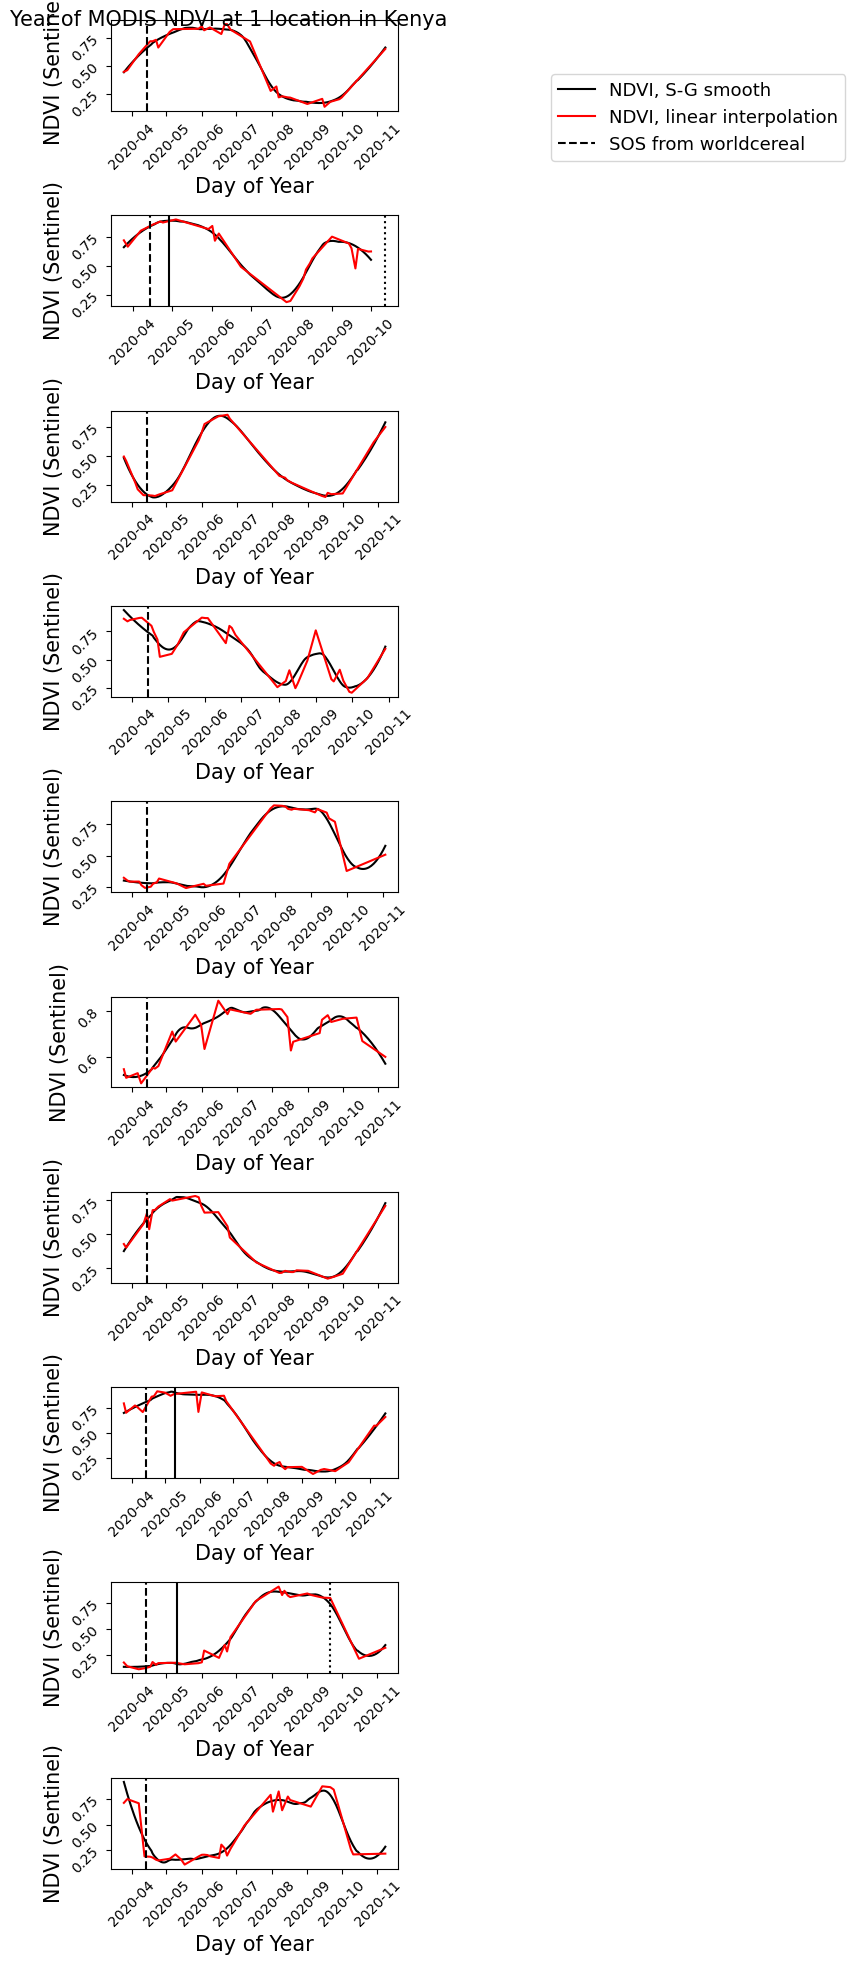

In [17]:
ds = pd.concat([ds1, ds2, ds3], axis = 0)
ds = ds.where(ds['NDVI'] != -9999).dropna()
ds = ds.where(ds['reducer'] == 'median').dropna()
ds['date'] = pd.to_datetime(ds['date'])
ds['year'] = ds['date'].dt.year
obs_data = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\observed_times.csv')
obs_data = obs_data.drop(columns=['Unnamed: 0', 'lat', 'lon'])
obs_data = obs_data.rename(columns={'Stations_id':'Stations_Id', 'Referenzjahr': 'year'})
ds = data_cleaning.add_EOS_to_df(ds)
ds = data_cleaning.add_SOS_to_df(ds)
ds = pd.merge(ds, obs_data, on=['Stations_Id', 'year'], how = 'outer')
#ds['NDVI'] = (ds['median sur_refl_b02'] - ds['median sur_refl_b01'])/(ds['median sur_refl_b02'] + ds['median sur_refl_b01'])
#ds['NDVI'] = normalized_difference(ds['median B8'], ds['median B4'])
#station = ds['Stations_Id'].unique()[0]
plot_many_NDVI_curves(ds, 2020, font_size = 15)

In [7]:
#ds = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\MODIS\\Germany\\satdata0_GER.csv')
#ds = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\MODIS\\Kenya\\satdata0_KEN.csv')#_KEN
#ds = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\Sentinel\\Kenya\\satdata0.csv')#_KEN
#ds = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\Sentinel\\Germany5\\satdata0.csv')
ds = ds.rename(columns = {'median ndvi': 'NDVI'}, inplace=False)
ds.loc[:, 'NDVI'] = -ds.loc[:, 'NDVI']
ds['year'] = pd.to_datetime(ds['formatted_time'], format='%Y-%m-%d-%H-%M-%S').dt.year
obs_data = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\observed_times.csv')
obs_data = obs_data.drop(columns=['Unnamed: 0', 'lat', 'lon'])
obs_data = obs_data.rename(columns={'Stations_id':'Stations_Id', 'Referenzjahr': 'year'})
ds = data_cleaning.add_EOS_to_df(ds)
ds = data_cleaning.add_SOS_to_df(ds)
ds = pd.merge(ds, obs_data, on=['Stations_Id', 'year'])
#ds['NDVI'] = (ds['median sur_refl_b02'] - ds['median sur_refl_b01'])/(ds['median sur_refl_b02'] + ds['median sur_refl_b01'])
#ds['NDVI'] = normalized_difference(ds['median B8'], ds['median B4'])
#station = ds['Stations_Id'].unique()[0]
plot_many_NDVI_curves(ds, 2020, font_size = 15)

KeyError: 'formatted_time'

c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\Satellite_Feature_Extraction\data_cleaning.py:41: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  ds = ds.resample('D').asfreq().interpolate()
c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\Satellite_Feature_Extraction\modelling_fctns.py:27: RuntimeWarning: overflow encountered in exp
  return a / (1 + np.exp(-b * (x - c))) + d / (1 + np.exp(-e * (x - f)))
c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\Satellite_Feature_Extraction\data_cleaning.py:41: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  ds = ds.resample('D').asfreq().interpolate()
c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\Satellite_Feature_Extraction\modelling_fctns.py:27: RuntimeWarning: overflow encounte

0 lat    54.4333
lon     9.8167
Name: 0, dtype: float64 2020-06-23 00:00:00
Couldn't interpolate
Couldn't interpolate
Couldn't interpolate
4 lat    54.2333
lon    11.0833
Name: 1810, dtype: float64 2020-10-28 00:00:00
5 lat    54.2500
lon    10.8333
Name: 2190, dtype: float64 2020-06-03 00:00:00
no maturity data
Couldn't interpolate
Couldn't interpolate
8 lat    54.6167
lon     9.8333
Name: 3685, dtype: float64 2020-07-31 00:00:00
9 lat    54.55
lon     9.40
Name: 4058, dtype: float64 2020-08-07 00:00:00
10 lat    54.4167
lon     9.5167
Name: 4430, dtype: float64 2020-08-07 00:00:00
11 lat    53.8167
lon    10.1500
Name: 4793, dtype: float64 2020-07-01 00:00:00
no maturity data
12 lat    53.6167
lon    10.4167
Name: 5159, dtype: float64 2020-06-23 00:00:00


c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\Satellite_Feature_Extraction\data_cleaning.py:41: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  ds = ds.resample('D').asfreq().interpolate()
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_11184\3218324012.py:30: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = scipy.optimize.curve_fit(double_logistic, Times/365, NDVIs, maxfev = 10000)
c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\Satellite_Feature_Extraction\data_cleaning.py:41: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  ds = ds.resample('D').asfreq().interpolate()
c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\Satellite_Feature_Extraction\modelling_fctns.py:27: RuntimeWarning: overflow 

no maturity data
Couldn't interpolate
Couldn't interpolate
15 lat    54.7333
lon     8.4333
Name: 6587, dtype: float64 2020-07-16 00:00:00


c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\Satellite_Feature_Extraction\data_cleaning.py:41: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  ds = ds.resample('D').asfreq().interpolate()
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_11184\3218324012.py:30: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = scipy.optimize.curve_fit(double_logistic, Times/365, NDVIs, maxfev = 10000)


IndexError: single positional indexer is out-of-bounds

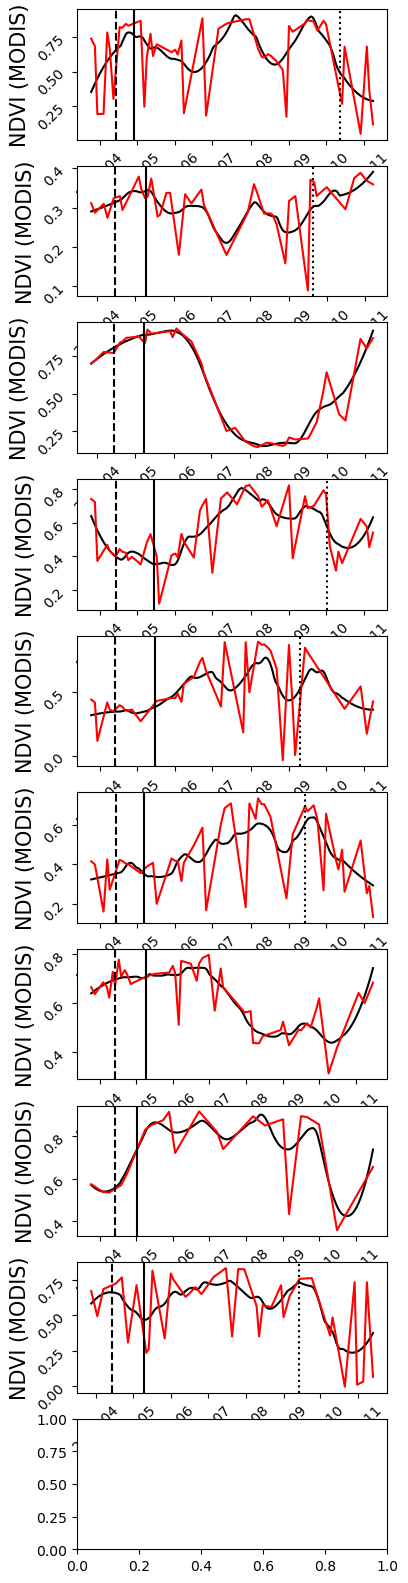

In [70]:
#ds = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\MODIS\\Germany\\satdata0_GER.csv')
#ds = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\MODIS\\Kenya\\satdata0_KEN.csv')#_KEN
#ds = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\Sentinel\\Kenya\\satdata0.csv')#_KEN
ds = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\Sentinel\\Germany\\satdata0.csv')
ds = ds.rename(columns = {'median ndvi': 'NDVI'}, inplace=False)
#ds.loc[:, 'NDVI'] = -ds.loc[:, 'NDVI']
ds['NDVI'] = normalized_difference(ds['median B8'], ds['median B4'])
ds['year'] = pd.to_datetime(ds['formatted_time'], format='%Y-%m-%d-%H-%M-%S').dt.year
obs_data = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\observed_times.csv')
obs_data = obs_data.drop(columns=['Unnamed: 0', 'lat', 'lon'])
obs_data = obs_data.rename(columns={'Stations_id':'Stations_Id', 'Referenzjahr': 'year'})
ds = pd.merge(ds, obs_data, on=['Stations_Id', 'year'])
ds = data_cleaning.add_EOS_to_df(ds)
ds = data_cleaning.add_SOS_to_df(ds)
#station = ds['Stations_Id'].unique()[0]
plot_many_NDVI_curves(ds, 2020, font_size = 15)

0 lat    54.4333
lon     9.8167
Name: 0, dtype: float64 2020-06-23 00:00:00
Couldn't interpolate
2 lat    54.7500
lon     9.5167
Name: 758, dtype: float64 2020-06-01 00:00:00
Couldn't interpolate
Couldn't interpolate
5 lat    54.2333
lon    11.0833
Name: 2244, dtype: float64 2020-10-28 00:00:00
6 lat    54.2500
lon    10.8333
Name: 2624, dtype: float64 2020-06-03 00:00:00


c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\Satellite_Feature_Extraction\modelling_fctns.py:27: RuntimeWarning: overflow encountered in exp
  return a / (1 + np.exp(-b * (x - c))) + d / (1 + np.exp(-e * (x - f)))
c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\Satellite_Feature_Extraction\modelling_fctns.py:27: RuntimeWarning: overflow encountered in exp
  return a / (1 + np.exp(-b * (x - c))) + d / (1 + np.exp(-e * (x - f)))
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_11184\558703886.py:25: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = scipy.optimize.curve_fit(double_logistic, Times/365, NDVIs, maxfev = 10000)
c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\Satellite_Feature_Extraction\modelling_fctns.py:27: RuntimeWarning: overflow encountered in exp
  return a / (1 + np.exp(-b * (x - c))) + d / (1 + np.exp(-e * (x - f)))
c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\Satellite_Feature_Extraction\modelling_fctns.py:27: 

7 lat    54.3167
lon    10.2167
Name: 3014, dtype: float64 2020-09-21 00:00:00
Couldn't fit
Couldn't interpolate
Couldn't interpolate
104.0
299.0


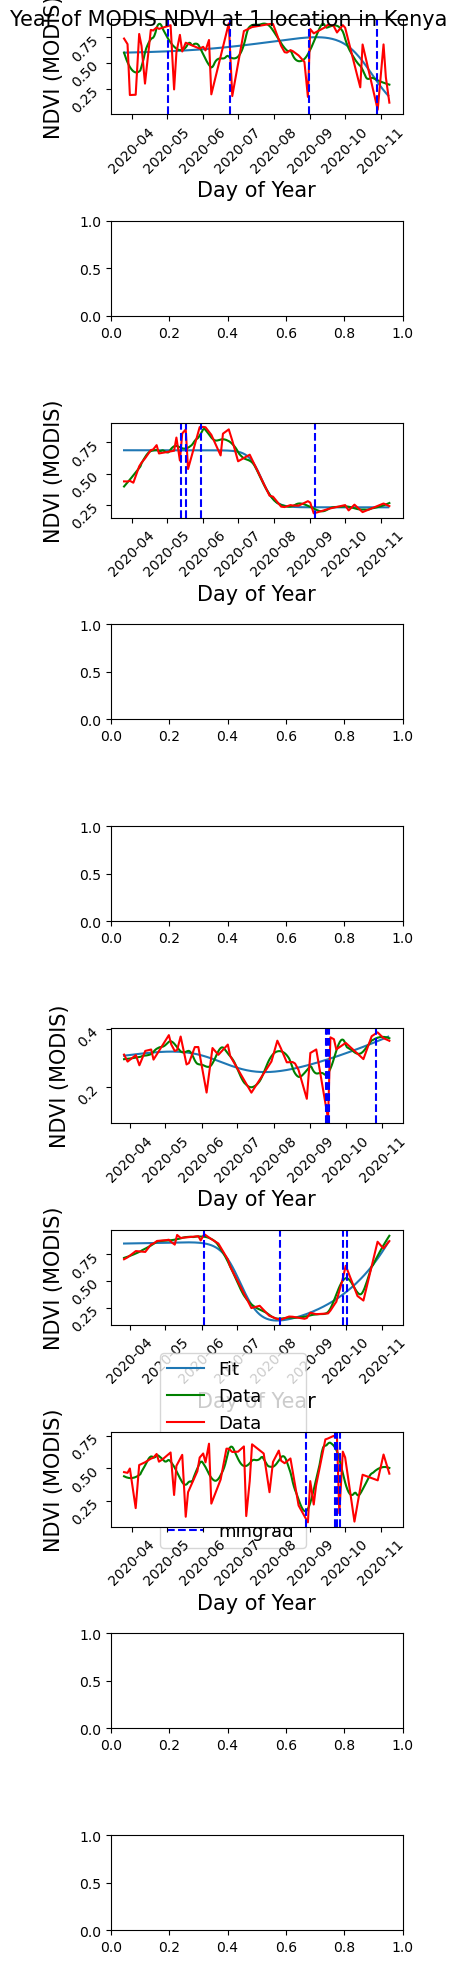

In [21]:
ds = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\Sentinel\\Germany\\satdata0.csv')
#ds['NDVI'] = (ds['median sur_refl_b02'] - ds['median sur_refl_b01'])/(ds['median sur_refl_b02'] + ds['median sur_refl_b01'])
ds['NDVI'] = normalized_difference(ds['median B8'], ds['median B4'])
#station = ds['Stations_Id'].unique()[0]
plot_many_NDVI_curves(ds, 2020, shift = 0, font_size = 15)

0 lat    54.3167
lon    10.0500
Name: 0, dtype: float64 2020-09-16 00:00:00
Couldn't fit
1 lat    54.4333
lon     9.8167
Name: 280, dtype: float64 2020-09-16 00:00:00
Couldn't interpolate
3 lat    53.9500
lon    10.6833
Name: 852, dtype: float64 2020-11-07 00:00:00
4 lat    54.7167
lon     9.9500
Name: 1130, dtype: float64 2020-06-26 00:00:00


c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\Satellite_Feature_Extraction\modelling_fctns.py:27: RuntimeWarning: overflow encountered in exp
  return a / (1 + np.exp(-b * (x - c))) + d / (1 + np.exp(-e * (x - f)))


5 lat    54.7500
lon     9.5167
Name: 1413, dtype: float64 2020-05-29 00:00:00
Couldn't fit
Couldn't interpolate
7 lat    53.6167
lon    10.7000
Name: 2240, dtype: float64 2020-07-13 00:00:00


c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\Satellite_Feature_Extraction\modelling_fctns.py:27: RuntimeWarning: overflow encountered in exp
  return a / (1 + np.exp(-b * (x - c))) + d / (1 + np.exp(-e * (x - f)))
c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\Satellite_Feature_Extraction\modelling_fctns.py:27: RuntimeWarning: overflow encountered in exp
  return a / (1 + np.exp(-b * (x - c))) + d / (1 + np.exp(-e * (x - f)))


8 lat    53.7000
lon    10.7833
Name: 2515, dtype: float64 2020-05-29 00:00:00
Couldn't interpolate


c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\Satellite_Feature_Extraction\modelling_fctns.py:27: RuntimeWarning: overflow encountered in exp
  return a / (1 + np.exp(-b * (x - c))) + d / (1 + np.exp(-e * (x - f)))
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_3520\1639666003.py:48: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[location_index - 3].legend(fontsize = font_size - 2, bbox_to_anchor=(0.7, -0.2))


104.0
300.0


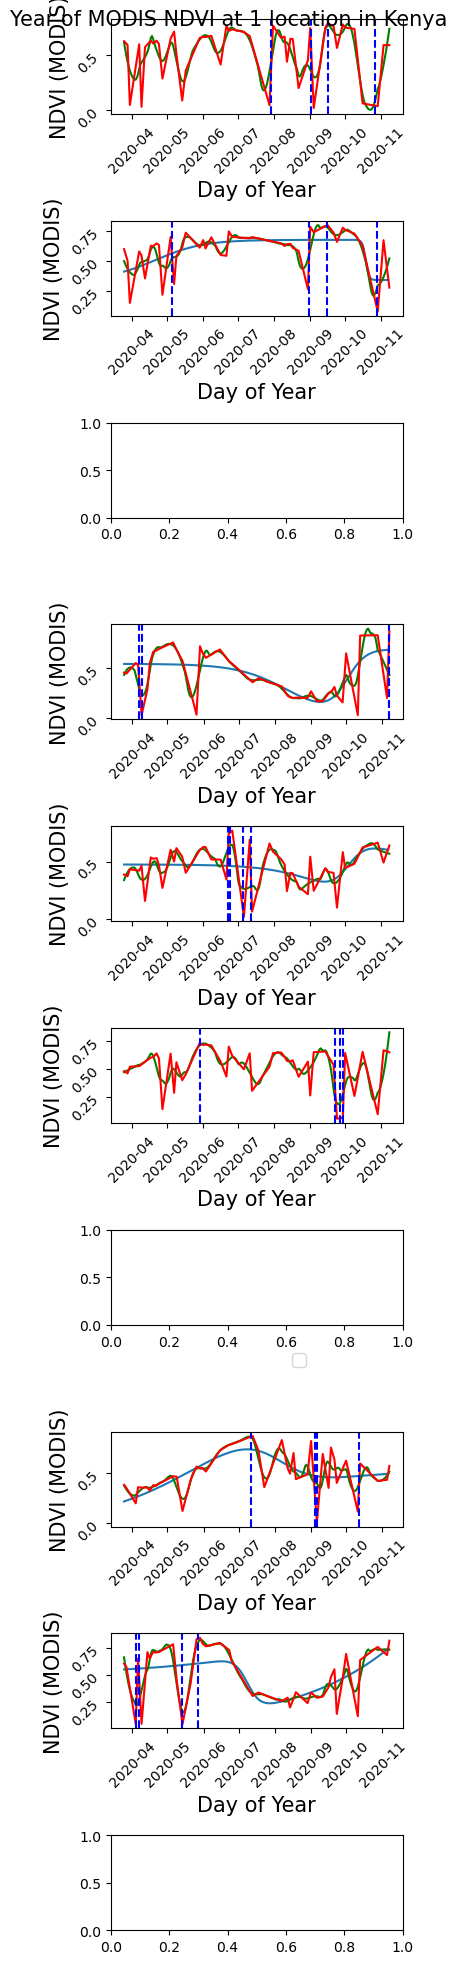

In [96]:
ds = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\Sentinel\\Germany4\\satdata0.csv')
#ds['NDVI'] = (ds['median sur_refl_b02'] - ds['median sur_refl_b01'])/(ds['median sur_refl_b02'] + ds['median sur_refl_b01'])
ds['NDVI'] = normalized_difference(ds['median B8'], ds['median B4'])
#station = ds['Stations_Id'].unique()[0]
plot_many_NDVI_curves(ds, 2020, shift = 0, font_size = 15)

In [234]:
pd.DatetimeIndex(max_value_interpolated['time']).min() + Times.astype('timedelta64[D]') #np.timedelta64(Times, 'D')

array([Timestamp('2021-09-23 00:00:00+0000', tz='UTC'),
       Timestamp('2021-10-01 00:00:00+0000', tz='UTC'),
       Timestamp('2021-10-09 00:00:00+0000', tz='UTC'),
       Timestamp('2021-10-17 00:00:00+0000', tz='UTC'),
       Timestamp('2021-10-25 00:00:00+0000', tz='UTC'),
       Timestamp('2021-11-02 00:00:00+0000', tz='UTC'),
       Timestamp('2021-11-10 00:00:00+0000', tz='UTC'),
       Timestamp('2021-11-18 00:00:00+0000', tz='UTC'),
       Timestamp('2021-11-26 00:00:00+0000', tz='UTC'),
       Timestamp('2021-12-04 00:00:00+0000', tz='UTC'),
       Timestamp('2021-12-12 00:00:00+0000', tz='UTC'),
       Timestamp('2021-12-20 00:00:00+0000', tz='UTC'),
       Timestamp('2021-12-28 00:00:00+0000', tz='UTC'),
       Timestamp('2022-01-05 00:00:00+0000', tz='UTC'),
       Timestamp('2022-01-13 00:00:00+0000', tz='UTC'),
       Timestamp('2022-01-21 00:00:00+0000', tz='UTC'),
       Timestamp('2022-01-29 00:00:00+0000', tz='UTC'),
       Timestamp('2022-02-06 00:00:00+0000', tz=

In [ ]:
def plot_many_NDVI_curves(ds, year, shift = 0, font_size = 15):#LSP_at_stations(ds, start_year, end_year, LSP_method = 'double_logistic', interp_method = 'MVI'):
    results = initialize_LSP_frame(LSP_method)
    print(results)
        for station in ds['Stations_Id'].unique():
            ds_station = ds.loc[(ds['lat'] == latlon['lat']) & (ds['lon'] == latlon['lon'])]#ds.loc[ds['Stations_Id'] == station]
            ds_station_year = data_cleaning.restrict_to_growing_season(ds_station, year, ds_station['SOS'].iloc[0], ds_station['EOS'].iloc[0])
            if len(ds_station_year) > 0:
                print(f'Station {station} in {year} has {len(ds_station_year)} observations')
            else:
                print(f'Station {station} in {year} has no observations')
                continue
            if interp_method == 'MVI':
                ds_interpolated = data_cleaning.map_max_value_int(ds_station_year, window_size=4) #data_cleaning.
            elif interp_method == 'linear':
                ds_interpolated = data_cleaning.resample_linear(ds_station_year)
            first_date = pd.DatetimeIndex(ds_interpolated['time']).min()
            Times = (pd.DatetimeIndex(ds_interpolated['time']) - pd.DatetimeIndex(ds_interpolated['time']).min()).days.values
            NDVIs = ds_interpolated['NDVI'].values
            try:
                results = calculate_append_LSP_frame(results, NDVIs, Times, first_date, LSP_method, year, station)
            except:
                print(f'Couldn\'t compute LSP for station {station} in year {year}')
                continue
    return results

IndentationError: unexpected indent (106857682.py, line 4)

array([  0,   8,  16,  24,  32,  40,  48,  56,  64,  72,  80,  88,  96,
       104, 112, 120, 128, 136, 144, 152, 160, 168],
      dtype='timedelta64[D]')

In [112]:
ds = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\MODIS\\Germany\\satdata0.csv')
#ds = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\MODIS\\Kenya\\satdata0.csv')
ds['NDVI'] = (ds['median sur_refl_b02'] - ds['median sur_refl_b01'])/(ds['median sur_refl_b02'] + ds['median sur_refl_b01'])
#station = ds['Stations_Id'].unique()[0]
latlon = ds.loc[:, ['lat', 'lon']].drop_duplicates().sample(1)
ds_station = ds.loc[(ds['lat'] == latlon['lat'].values[0]) & (ds['lon'] == latlon['lon'].values[0])]
#ds_station = ds.loc[(ds['Stations_Id'] == station)]
ds_year = ds_station.loc[pd.DatetimeIndex(ds_station['formatted_time']).year  == 2021]
max_value_interpolated = data_cleaning.map_max_value_int(ds_year, window_size=8)
Times = pd.DatetimeIndex(max_value_interpolated['formatted_time']).dayofyear.values
NDVIs = max_value_interpolated['NDVI'].values

params, _ = scipy.optimize.curve_fit(double_logistic, Times/365, NDVIs, maxfev = 10000)

c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\Satellite_Feature_Extraction\modelling_fctns.py:27: RuntimeWarning: overflow encountered in exp
  return a / (1 + np.exp(-b * (x - c))) + d / (1 + np.exp(-e * (x - f)))


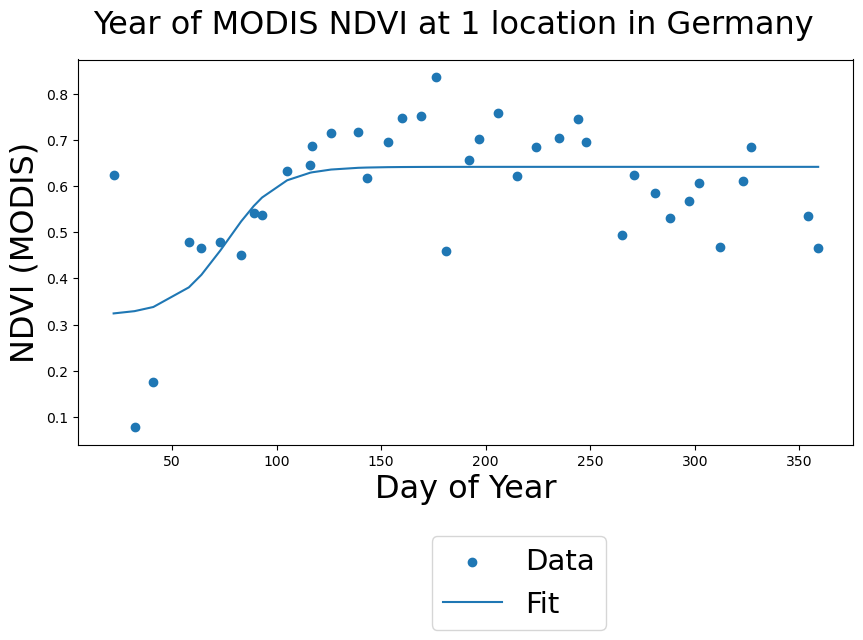

In [113]:
font_size = 23
fig, ax = plt.subplots(figsize = (10, 5))
ax.scatter(Times, NDVIs, label = 'Data')
ax.plot(Times, double_logistic(Times/365, *params), label = 'Fit')
ax.set_xlabel('Day of Year', fontsize = font_size)
ax.set_ylabel('NDVI (MODIS)', fontsize = font_size)
fig.suptitle('Year of MODIS NDVI at 1 location in Germany', fontsize = font_size)
ax.legend(fontsize = font_size - 2, bbox_to_anchor=(0.7, -0.2))

In [53]:
X = (array_input2['NDVI'] - array_input2['NDVI'].mean(dim='sample')).values
np.corrcoef(X.T)

array([[1.        , 0.83662139, 0.74261934, 0.73125136, 0.70882541],
       [0.83662139, 1.        , 0.80827924, 0.75418058, 0.65950048],
       [0.74261934, 0.80827924, 1.        , 0.76833473, 0.60545472],
       [0.73125136, 0.75418058, 0.76833473, 1.        , 0.71443907],
       [0.70882541, 0.65950048, 0.60545472, 0.71443907, 1.        ]])

In [37]:
ds2 = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\MODIS\\Germany\\satdata0.csv')
ds2['NDVI'] = normalized_difference(ds['median sur_refl_b02'], ds['median sur_refl_b01'])
max_value_interpolated2 = data_cleaning.map_max_value_int(ds2, window_size=8)
sampled_locs_input2 = make_tensor_from_timeseries(max_value_interpolated2, sample_number = 100, m_window_size = 5, format_choice = 'numpy')

In [40]:
sampled_locs_input.shape

(95, 20)

In [51]:
np.mean(sampled_locs_input, axis=0).shape

(20,)

In [19]:
X = sampled_locs_input - np.mean(sampled_locs_input, axis=0)
Z = sampled_locs_input2 - np.mean(sampled_locs_input2, axis=0)

In [20]:
X.shape

(95, 20)

In [21]:
TCA = libtlda.tca.TransferComponentClassifier(kernel_type='sigmoid', num_components = 3)
C, K = TCA.transfer_component_analysis(X, Z)

Adding regularization: 1e-06
Adding regularization: 1e-05
Adding regularization: 0.0001
Adding regularization: 0.001
Adding regularization: 0.01
Adding regularization: 0.1
Adding regularization: 1
Adding regularization: 10
Adding regularization: 100


c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\libtlda\tca.py:108: RuntimeWarning: overflow encountered in exp
  return 1./(1 + np.exp(np.dot(X, Z.T)))


In [26]:
adapter = adapt.feature_based.fMMD()
#X_emb.shape
adapter.fit_transform(X, Z)
adapter.transform(np.array([range(20)]))

     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -2.1000e+01  2e+01  1e+00  1e+00
 1:  9.0706e-02 -1.4078e+01  2e+01  7e-01  7e-01
 2:  1.3885e-01 -1.0046e+01  1e+01  5e-01  5e-01
 3:  8.5195e-02 -3.4231e+00  4e+00  4e-12  2e-16
 4:  8.5203e-04 -3.4231e-02  4e-02  7e-14  3e-16
 5:  8.5211e-06 -3.4231e-04  4e-04  8e-14  5e-17
 6:  8.5215e-08 -3.4231e-06  4e-06  5e-13  1e-16
 7:  8.4653e-10 -3.4233e-08  4e-08  9e-13  1e-16
Optimal solution found.


array([[17]])

In [28]:
adapter.selected_features_

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False])

In [ ]:
plt.imshow(np.corrcoef(X.T))

In [ ]:

    #return cross_percentile_date(smoothed_series, 10), cross_percentile_date(smoothed_series, 50), cross_percentile_date(smoothed_series, 90), max_green #Tighter_times[np.int64(smoothed_series.idxmax()*365)]

In [ ]:
fd['time'] = pd.DatetimeIndex(fd['time']).dayofyear
fd = FDataGrid(
    grid_points=fd['time'],
    data_matrix=np.array([fd['NDVI'].values]),
)
latlon = ds.loc[:, ['lat', 'lon']].drop_duplicates().sample(1)
ds_station = ds.loc[(ds['lat'] == latlon['lat'].values[0]) & (ds['lon'] == latlon['lon'].values[0])]
#ds_station = ds.loc[(ds['Stations_Id'] == station)]
ds_year = ds_station.loc[pd.DatetimeIndex(ds_station['formatted_time']).year  == 2021]
max_value_interpolated = data_cleaning.map_max_value_int(ds_year, window_size=8)
fd = max_value_interpolated[['NDVI', 'formatted_time']]
fd = fd.rename(columns = {'formatted_time':'time'}).reset_index().drop(['formatted_time', 'level_1'], axis = 1)
os = NadarayaWatsonHatMatrix(bandwidth=60)
fd_os = KernelSmoother(
    kernel_estimator=os,
    output_points=np.arange(10, 350)
)
os_fitted = fd_os.fit_transform(fd)

us = NadarayaWatsonHatMatrix(bandwidth=20)
fd_us = KernelSmoother(
    kernel_estimator=us,
    output_points=np.arange(10, 350)
)
us_fitted = fd_us.fit_transform(fd)
fig, ax = plt.subplots()
ax.plot(fd_os.output_points.squeeze(), os_fitted.data_matrix.squeeze(), color = 'black', linestyle='--')
ax.plot(fd_us.output_points.squeeze(), us_fitted.data_matrix.squeeze(), color = 'black', linestyle=':')
ax.scatter(fd.grid_points, fd.data_matrix.squeeze(), color='red')